In [4]:
%matplotlib notebook
import sys
# add path to pair interaction installation
# see pairinteraction.github.io
sys.path.append('../pairinteraction/build')
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from libpairinteraction import pireal as pi
cache_dir = './cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

In [5]:
distance = 10  # mu
bfields = np.linspace(0, 20, 200)  # gauss

In [9]:
state_one = pi.StateOne('Rb', 43, 2, 2.5, 0.5)
state_two = pi.StateTwo(state_one, state_one)

In [16]:
def setup_system_one(bfield):
    system_one = pi.SystemOne(state_one.element, cache_dir)
    system_one.restrictEnergy(state_one.energy-100, state_one.energy+100)
    system_one.restrictN(state_one.n-2, state_one.n+2)
    system_one.restrictL(state_one.l-2, state_one.l+2)
    system_one.setBfield([0, 0, bfield])
    return system_one

In [23]:
def setup_system_two(system_one, distance, angle):
    system_two = pi.SystemTwo(system_one, system_one, cache_dir)
    system_two.restrictEnergy(state_two.energy-5, state_two.energy+5)
    system_two.setDistance(distance)
    system_two.setAngle(angle)
    if angle == 0:
        system_two.setConservedMomentaUnderRotation([int(2*state_one.m)])
    system_two.setConservedParityUnderInversion(pi.ODD)
    system_two.setConservedParityUnderPermutation(pi.ODD)
    return system_two

In [24]:
def getEnergies(bfield, distance, angle):
    # Set up one atom system
    system_one = setup_system_one(bfield)
    system_one.diagonalize()

    # Calculate Zeeman shift
    zeemanshift = 2*system_one.diagonal[system_one.getVectorindex(state_one)] # GHz

    # Set up two atom system
    system_two = setup_system_two(system_one, distance, angle)
    system_two.diagonalize()

    # Calculate blockade interaction
    eigenenergies = (system_two.diagonal-zeemanshift)*1e3 # MHz
    overlaps = system_two.getOverlap(state_two)
    blockade = 1/np.sqrt(np.sum(overlaps/eigenenergies**2))

    return blockade

<IPython.core.display.Javascript object>


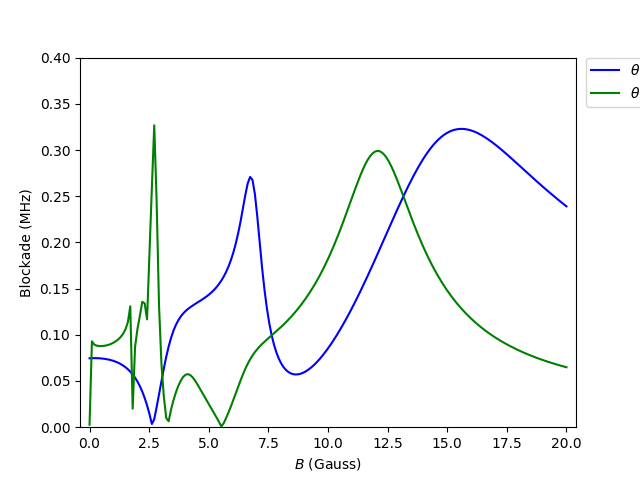

In [25]:
plt.xlabel(r"$B$ (Gauss)")
plt.ylabel(r"Blockade (MHz)")
plt.xlim(-0.4,20.4)
plt.ylim(0,0.4)

energies1 = list(map(partial(getEnergies, distance=distance, angle=0), bfields))
energies2 = list(map(partial(getEnergies, distance=distance, angle=np.pi/2), bfields))

plt.plot(bfields, energies1, 'b-', label=r"$\theta = 0$")
plt.plot(bfields, energies2, 'g-', label=r"$\theta = \pi/2$")
plt.legend(loc=2, bbox_to_anchor=(1.02, 1), borderaxespad=0)